# 자동차 매출 데이터를 이용한 리포트 작성

## 데이터 생성

* 앞서 다운받았던 classicmodels DB이용
* 새로운 데이터를 받으면 데이터가 어떻게 구조화되어 있는지 파악해야 한다.
* 쉽게 파악하기 위해서 ERD(Entity Relational Diagram)를 작성한다.
* ERD가 존재한다면 빠르고 쉽게 데이터 구조를 파악할 수 있으나, 현업에서는 ERD가 존재하지 않는 경우가 다수이므로 직접 데이터를 조회하면서 파악해야 하는 경우가 많다.
* classicmodels의 ERD는 다음과 같다.

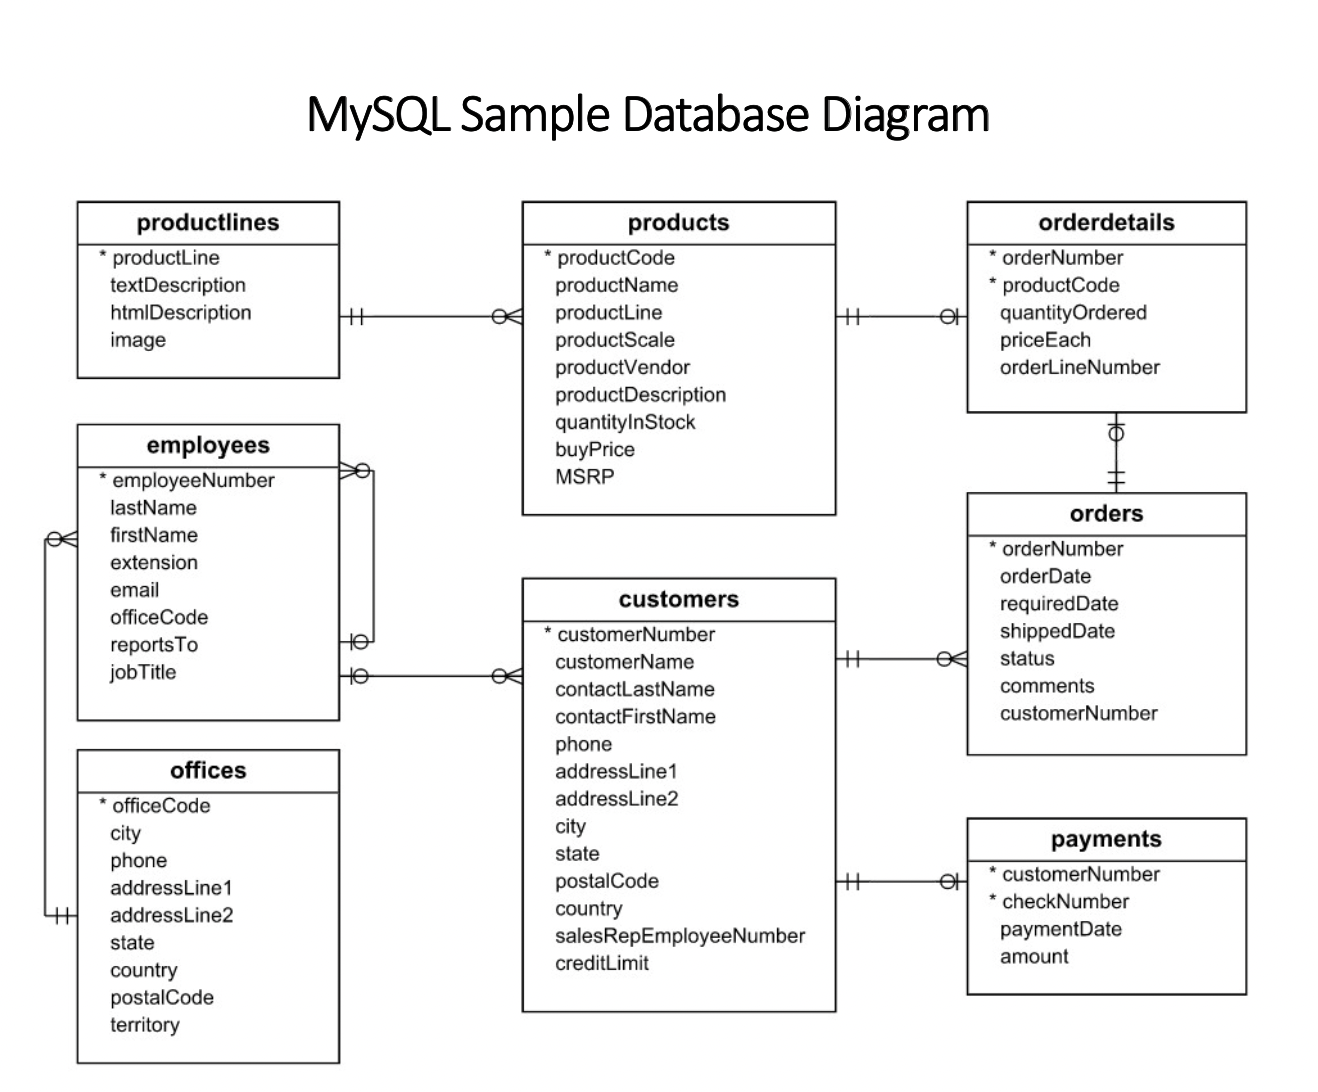

## 구매 지표 추출

* 매출액(일자별, 월별, 연도별)
* 구매자 수, 구매 건수(일자별, 월별, 연도별)
* 인당 매출액(AMV, Average Member Value) (연도별)
* 건당 구매 금액(ATV, Average Transaction Value) (연도별)

### 1. 매출액(일자별, 월별, 연도별)

#### 일별 매출액 조회

* 일별 매출액을 조회하려면 주문의 주문일과 판매액이 필요
* ERD에서 주문 일자(orderdate)는 orders테이블에 존재하고, 판매액(priceEach * quantityOrdered)은 orderdetails에 존재한다.
* 우리는 orders테이블의 주문정보에 orderdetails의 주문 상품 가격을 결합해야 한다.

In [ ]:
# 테이블 결합 후, 일별 매출액을 조회
USE classicmodels
SELECT A.orderDate, (priceEach * quantityOrdered) as totalPrice
FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
;

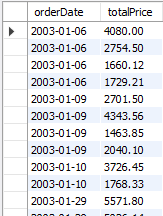

In [ ]:
# orderdate로 그루핑한 뒤 매출액의 합을 집계하여 일별 매출액 계산
SELECT A.orderDate, SUM(priceEach * quantityOrdered) as Sales
FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
# GROUP BY 1
GROUP BY A.orderDate
ORDER BY 1
;

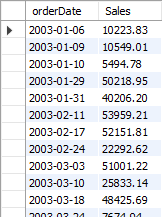

#### 월별 매출액 조회

* 판매일(orderdate)은 'yyyy-mm-dd'의 형태로 구성되어 있다.
* orderdate에서 'yyyy-mm'만 가져올 수 있다면 월별 매출액을 조회할 수 있을 것이다.
* 문자열에서 원하는 텍스트만 호출하는 함수는 SUBSTR()가 있다.

In [ ]:
# SUBSTR()을 이용해 월별 매출을 구하는 방법
SELECT SUBSTR(A.orderDate, 1, 7) MM, SUM(priceEach * quantityOrdered) as Sales
FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
# GROUP BY 1
GROUP BY SUBSTR(A.orderDate, 1, 7)
ORDER BY 1
;

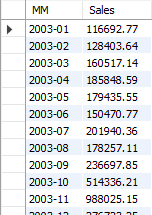

#### 연도별 매출액 조회

* 연도별 매출액 역시 위의 월별 매출액과 동일한 방법으로 구할 수 있다.

In [ ]:
# 연도별 매출액
SELECT SUBSTR(A.orderDate, 1, 4) YY, SUM(priceEach * quantityOrdered) as Sales
FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
GROUP BY 1
ORDER BY 1
;

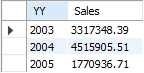

### 2. 구매자 수, 구매 건수(일자별, 월별, 연도별)

* ERD를 살펴보면 orders테이블에 판매일(orderDate), 구매 고객 번호(customerNumber)가 존재한다.
* 따라서 판매일로 그루핑한 후 고객 번호를 COUNT해주면 된다.
* 주의해야 할 점은 구매자 수, 구매 건수를 산출할 때는 보통 UNIQUE하게 필드를 COUNT해줘야 한다는 점이다.

In [ ]:
# 판매일로 그루핑한 후 고객 번호를 COUNT
SELECT orderDate, customerNumber, orderNumber
FROM orders;

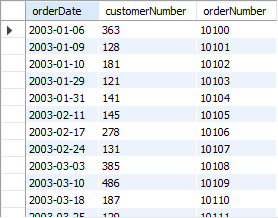

* customerNumber를 보면 동일한 고객 번호가 여러 줄 생성되어 있음을 확인할 수 있다.
* 한 명의 고객이 여러 번 구매할 수 있어 충분히 있을 수 있는 상황임 -> 만약 고객 번호를 단순히 COUNT로 집계한다면, 한 명의 고객을 여러 번 집계하게 된다.
* 고객 번호는 중복을 제외한 값을 세어야 한다.
* 중복을 제거하고 값을 세려면 COUNT(DISTINCT 컬럼)을 사용한다.

* 주문번호 -> 중복 존재X, DISTINCT 사용할 필요는 없다.
* 만약 데이터의 구조를 파악하고 있다면 언제 중복을 제거해야 하는지 쉽게 알 수 있겠지만 대부분은 데이터의 구조를 파악하지 못한 상태에서 분석을 시작해야 하는 경우가 많다.
* 이런 상황에서는 어떻게 컬럼에 중복된 값이 있는지 확인할 수 있을까?

In [ ]:
# 데이터의 구조를 파악하지 못한 상태에서 분석을 시작해야 하는 경우, 컬럼에 중복된 값이 있는지 확인
SELECT COUNT(orderNumber) N_Orders, COUNT(DISTINCT orderNumber) N_Orders_Distinct
FROM orders;

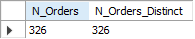

* 어떤 컬럼을 단순히 카운트한 값과 중복을 제거하고 카운트한 값이 같다면, 해당 컬럼에는 현재로서는 중복된 값이 없다고 판단할 수 있다.
* 그렇기 때문에 orderNumber는 중복을 제거하지 않고 카운트해도 상관없으나, 정확히는 테이블의 컬럼 속성을 보고 PK로 중복을 허용하지 않는지 확인하는 것이 좋다.

In [ ]:
# PK로 중복을 허용하지 않는지 확인 후 일별 구매자 수, 구매 건수 확인
SELECT orderDate, COUNT(DISTINCT customerNumber) N_Purchaser, COUNT(orderNumber) N_Orders
FROM orders
GROUP BY 1
ORDER BY 1;

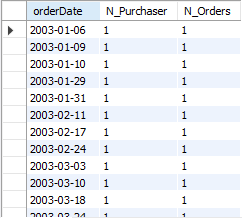

In [ ]:
# 월별 구매자 수, 구매 건수
SELECT SUBSTR(orderDate, 1, 7) MM, COUNT(DISTINCT customerNumber) N_Purchaser, COUNT(orderNumber) N_Orders
FROM orders
GROUP BY 1
ORDER BY 1;

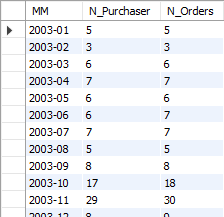

In [ ]:
# 연도별 구매자 수, 구매 건수
SELECT SUBSTR(orderDate, 1, 4) YY, COUNT(DISTINCT customerNumber) N_Purchaser, COUNT(orderNumber) N_Orders
FROM orders
GROUP BY 1
ORDER BY 1;

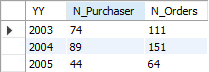

### 3. 인당 매출액(연도별)

* 고객의 인당 매출액은 고객의 로열티(Loyalty)를 측정하는 요인으로 사용 -> 기간별로 평균 인당 고객 매출액을 비교하면, 고객 1명이 우리의 서비스에 얼마를 지불하는지 그 변화를 파악할 수 있다.
* 연도별 인당 매출액은 다음과 같이 구할 수 있다. 먼저 연도별 매출액과 구매자 수를 구한다.

In [ ]:
# 연도별 매출액과 구매자 수 구하기
SELECT SUBSTR(A.orderDate, 1, 4) YY, COUNT(DISTINCT A.customerNumber) N_Purchaser, SUM(priceEach * quantityOrdered) as Sales
FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
GROUP BY 1
ORDER BY 1;

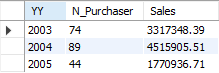

* 이후 매출액 수를 구매자 수로 나누면 된다.
* SUM(priceEach * quantityOrdered) / COUNT(DISTINCT A.customerNumber)를 추가해주면 된다.

In [ ]:
# 평균 인당 매출액 추가하기(AMV)
SELECT SUBSTR(A.orderDate, 1, 4) YY, COUNT(DISTINCT A.customerNumber) N_Purchaser, SUM(priceEach * quantityOrdered) as Sales,
SUM(priceEach * quantityOrdered)/COUNT(DISTINCT A.customerNumber) AMV
FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
GROUP BY 1
ORDER BY 1;

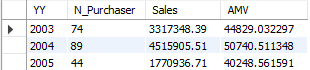

### 4. 건당 구매 금액(ATV, Average Transaction Value) (연도별)

* 1건의 거래는 평균적으로 얼마의 매출을 발생시키는지 확인 -> ATV
* 위에서 구했던 인당 구매 금액(AMV)을 구하는 방법과 유사한데, 매출을 구매자 수가 아닌 구매 건수로 나누어 주면 건당 구매 금액을 구할 수 있다.

In [ ]:
# 건당 구매 금액(ATV)
SELECT SUBSTR(A.orderDate, 1, 4) YY, COUNT(DISTINCT A.customerNumber) N_Purchaser, SUM(priceEach * quantityOrdered) as Sales,
SUM(priceEach * quantityOrdered)/COUNT(DISTINCT A.orderNumber) ATV
FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
GROUP BY 1
ORDER BY 1;

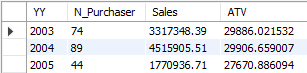

## 그룹별 구매 지표 구하기

* 국가별, 도시별 매출액
* 북미 vs 비북미 매출액 비교
* 매출 Top 5 국가 및 매출
* 국가별 Top Product 및 배출

### 1. 국가별, 도시별 매출액

* 해당 주문 건이 발생한 국가, 도시를 파악하기 위해서 customers 테이블의 country를 이용해야 한다.
* orders, customers, orderdetails를 모두 사용해야 국가별, 도시별 매출액을 구할 수 있다.

* 먼저 orders, customers, orderdetails 3가지 테이블을 결합해야 한다.
* 각 테이블을 연결하는 필드는 orderNumber, customerNumber이다.

In [ ]:
# orders, customers, orderdetails 3가지 테이블 결합
SELECT * FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
LEFT JOIN customers C
ON A.customerNumber = C.customerNumber;

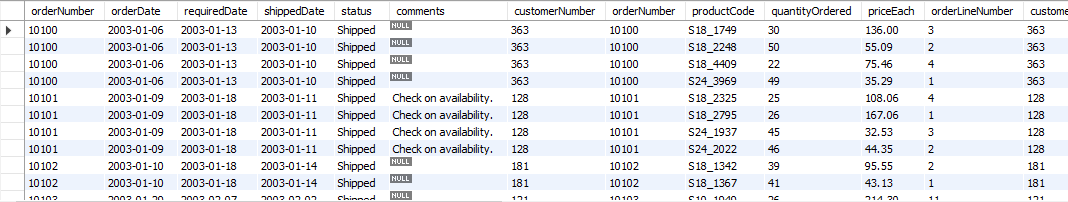

* 필요한 컬럼만 조회한다.

In [ ]:
# country, city, priceEach * quantityOrdered만 조회
SELECT C.country, C.city, priceEach * quantityOrdered FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
LEFT JOIN customers C
ON A.customerNumber = C.customerNumber;

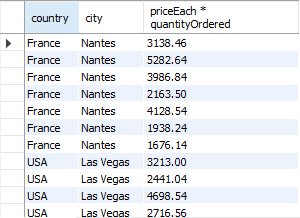

* country, city로 그루핑한 뒤 매출액을 합하면 국가별, 도시별 매출액을 구할 수 있다.

In [ ]:
# country, city로 그루핑한 뒤 매출액을 합하기
SELECT C.country, C.city, SUM(priceEach * quantityOrdered) Sales FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
LEFT JOIN customers C
ON A.customerNumber = C.customerNumber
GROUP BY 1, 2;

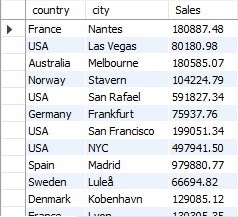

* customers 테이블에서 국가(country), 도시(city)를 불러오고, 2가지 컬럼으로 그루핑한다.
* 이후 orderdetails테이블의 priceEach * quantityOrdered를 합해 국가별, 도시별 매출액을 구한다.
* 마지막으로 country, city로 데이터를 정렬하면 데이터를 가독성 있게 구조화할 수 있다.

In [ ]:
# 그루핑 후 country, city로 정렬
SELECT C.country, C.city, SUM(priceEach * quantityOrdered) Sales FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
LEFT JOIN customers C
ON A.customerNumber = C.customerNumber
GROUP BY 1, 2
ORDER BY 1, 2;

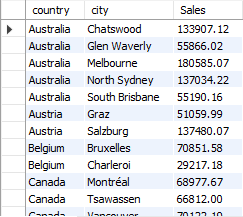

### 2. 북미(USA, Canada) vs 비북미 매출액 비교

* 북미와 비북미 지역 2가지로 구분해 매출을 조회하려면 CASE WHEN 조건문을 사용하면 된다.

#### CASE WHEN 구문
* CASE WHEN 조건 THEN 결과 END;

* 북미(USA, Canada)와 비북미를 구분하는 CASE WHEN 구문은 다음과 같다.

In [ ]:
# case when구문 사용하여 북미,비북미 구분
SELECT CASE WHEN country IN('USA', 'Canada') THEN 'North America' ELSE 'Ohers' END Country_GRP
FROM customers;

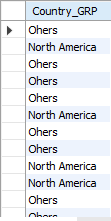

#### 국가별, 도시별 매출액

In [ ]:
# 국가별, 도시별 매출액
SELECT C.country, C.city, SUM(priceEach * quantityOrdered) Sales FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
LEFT JOIN customers C
ON A.customerNumber = C.customerNumber
GROUP BY 1, 2
ORDER BY 3 DESC;

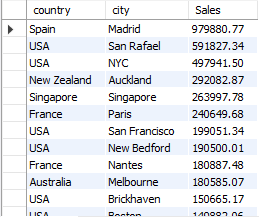

* 위의 쿼리를 보면 country와 city로 데이터를 그룹핑해 매출을 집계 -> country, city를 case when구문으로 변경하면 북미, 비북미의 매출을 구분해 조회할 수 있다.

#### 북미, 비북미 매출액

In [ ]:
# 북미, 비북미 매출액
SELECT CASE WHEN country IN('USA', 'Canada') THEN 'North America' ELSE 'Ohers' END Country_GRP,
SUM(priceEach * quantityOrdered) Sales FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
LEFT JOIN customers C
ON A.customerNumber = C.customerNumber
GROUP BY 1
ORDER BY 2 DESC;

#### 매출 Top5 국가 및 매출

* 데이터에 따라 등수를 매기는 함수가 필요하다.
* row_number, rank, dense_rank

* 국가별 매출액을 다른 이름의 테이블로 생성한 후, 매출에 따라 RANK를 매기면 우리가 원하는 Top 5 국가를 산출할 수 있다.

In [ ]:
# 새로운 테이블 생성 후 rank를 이용하여 매출Top 5국가 산출
CREATE TABLE stat as
SELECT C.country, SUM(priceEach * quantityOrdered) Sales
FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
LEFT JOIN customers C
ON A.customerNumber = C.customerNumber
GROUP BY 1
ORDER BY 2 DESC;

* 위의 쿼리를 실행하면 classicmodels 데이터베이스에 쿼리의 실행 결과가 stat라는 테이블 명으로 생성된다.
* 조회를 하면 다음과 같이 나온다.

In [ ]:
# stat테이블 조회
SELECT * FROM stat;

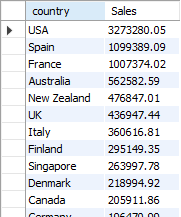

* DENSE_RANK를 이용하여 매출액 등수를 확인해본다.

In [ ]:
# DENSE_RANK를 이용하여 매출액 등수 확인
SELECT country, sales,
DENSE_RANK() OVER(ORDER BY sales DESC) RNK
FROM stat;

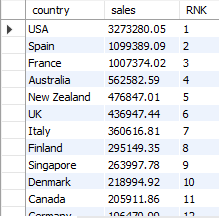

In [ ]:
# 위 결과를 stat_rnk테이블로 생성하여 조회
CREATE TABLE stat_rnk AS
SELECT country, sales,
DENSE_RANK() OVER(ORDER BY sales DESC) RNK
FROM stat;

SELECT * FROM stat_rnk;

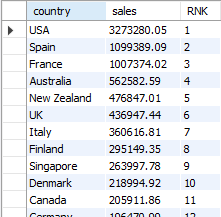

In [ ]:
# 상위 5개 국가를 추출
SELECT * FROM stat_rnk
WHERE RNK BETWEEN 1 AND 5;

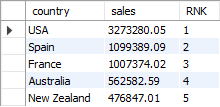

* 원하는 결과를 출력했으나, 2개의 테이블을 생성해 원하는 결과를 출력했다.
* 데이터를 조회할 때마다 이렇게 테이블을 생성한다면, DB는 금방 임시로 생성한 테이블로 가득차고 관리하기 어려워질 것이다.
* 이때 SUBQUERY를 이용하면, 이 과정을 하나의 쿼리로 처리할 수 있다.

#### SUBQUERY
* 다른 하나의 SQL문장의 절에 포함된 SELECT문장
* 앞서 WHERE절의 IN연산자에 사용되었던 SELECT문도 서브쿼리의 일종이다.

In [ ]:
# 서브쿼리를 사용하여 데이터 조회
SELECT * FROM
(SELECT country, sales,
DENSE_RANK() OVER(ORDER BY sales DESC) RNK
FROM
(SELECT C.country, SUM(priceEach * quantityOrdered) Sales
FROM orders A
LEFT JOIN orderdetails B
ON A.orderNumber = B.orderNumber
LEFT JOIN customers C
ON A.customerNumber = C.customerNumber
GROUP BY 1) A) A
WHERE RNK <=5;

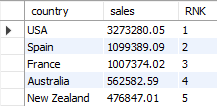

* RNK(순위)에 조건을 걸기 위해서 다시 서브쿼리를 생성하는 이유 -> WHERE절은 FROM에 위치한 테이블에서만 조건을 걸 수 있다.
* 그런데 RNK는 SELECT에서 생성한 컬럼이라 조건절에서 사용할 수 없다.
* 즉 SELECT에서 생성한 필드는 조건절에서 사용할 수 없어 다시 서브쿼리를 생성(하나의 테이블을 만드는 효과)해 FROM에 위치시키고, WHERE절에서 RNK로 조건을 걸어야 한다.
* 서브쿼리를 이용하면 한 번에 데이터를 조회할 수 있지만, 그 수가 많아지면 퍼포먼스에 부정적인 영향을 미칠수도 있다. 따라서 상황에 맞게 적절한 수로 사용할 필요가 있다.